# Diabetes Prediction

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on the following 8 diagnostic measurements.

    Pregnancies: Number of times pregnant
    GlucosePlasma: glucose concentration a 2 hours in an oral glucose tolerance test
    BloodPressure: Diastolic blood pressure (mm Hg)
    SkinThicknessTriceps: skin fold thickness (mm)
    Insulin: 2-Hour serum insulin (mu U/ml)
    BMI: Body mass index (weight in kg/(height in m)^2)
    DiabetesPedigreeFunction: Diabetes pedigree function
    Age: Age (years)

The dataset includes data from 768 women beyond the age of 21. The target variable:

    Outcome: Class variable (0 or 1), where 1 corresponds to having diabetes. 

### Goals of this notebook

* Look deeper into various ensembling methods and compare their performance.

**Classifiers used:**
    * Dummy Classifiers
    * Decision Tree 
    * Bagging Classifier
    * Random Forests
    * Sklearn's GBM
    * XgBoostClassifier
    * Stacking Classifier
    
 
 ### Notebook Structure
     * Import Libraries and Load data
     * Perform Exploratory Data Analysis and Data Cleaning
     * Build ensemble Models 
     * Compare the different ensemble models

## Import Libraries and Load  data

In [1]:
# Load the dependencies

import numpy as np
import pandas as pd 
import os

#Import sklearn classes 
from sklearn.model_selection import train_test_split,RepeatedKFold, cross_val_score,KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# sklearn utility to compare algorithms
from sklearn import model_selection

#Visualisation Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 

import warnings  
warnings.filterwarnings('ignore')

from eli5 import explain_weights,show_weights
from yellowbrick import ROCAUC
from yellowbrick.classifier import ClassificationReport

print("Imported all libraries successfully")
#print(os.listdir("../input"))

CV_N_REPEATS=20
BINS=10

Imported all libraries successfully


In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print('Shape of the dataset', df.shape)

Shape of the dataset (768, 9)


## EDA and Data Cleaning

We first check if the data is shuffled. We can do that by plotting the Outcome against the dataframe index (in x-axis).

Text(0, 0.5, 'Outcome')

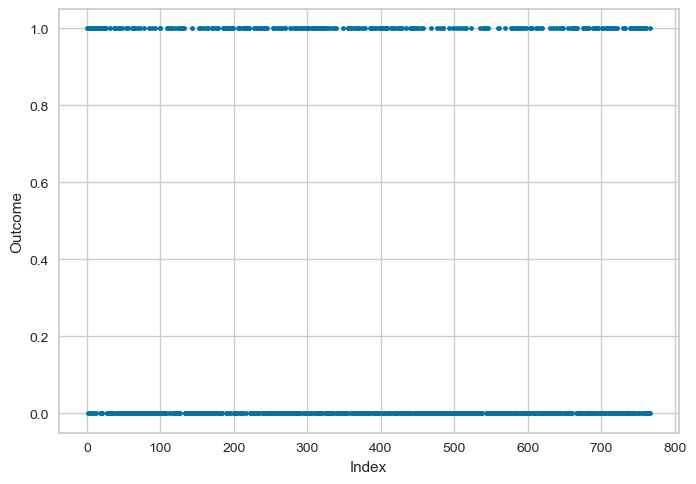

In [4]:
plt.figure()
plt.plot(df.Outcome,'.')
plt.xlabel('Index')
plt.ylabel('Outcome')

The above plot confirms that the dataframe rows are shuffled. That is good. We next check for class imbalance. As can be seen from the below figure, there's fewer samples with diabeties than the ones not having diabetes. To tackle this imbalance, we would make use of Stratified sampling during the model building phase.

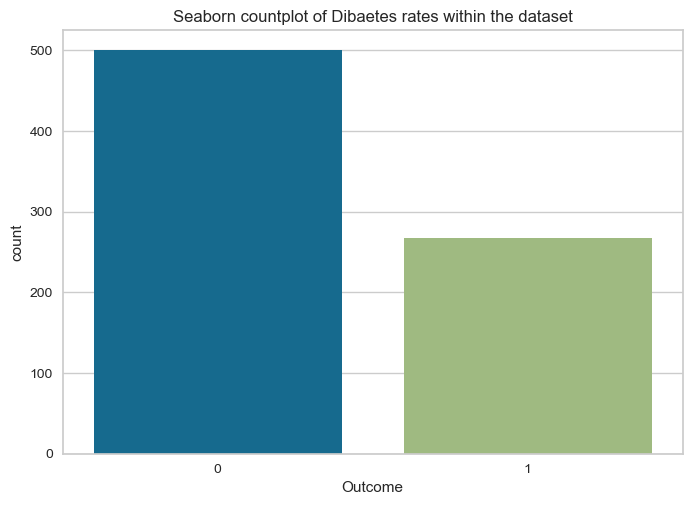

In [5]:
plt.figure()
ax = sns.countplot(data=df, x='Outcome');
ax.set_title("Seaborn countplot of Dibaetes rates within the dataset");

We check the distribution of the 8 attributes against the target variable Outcome.  

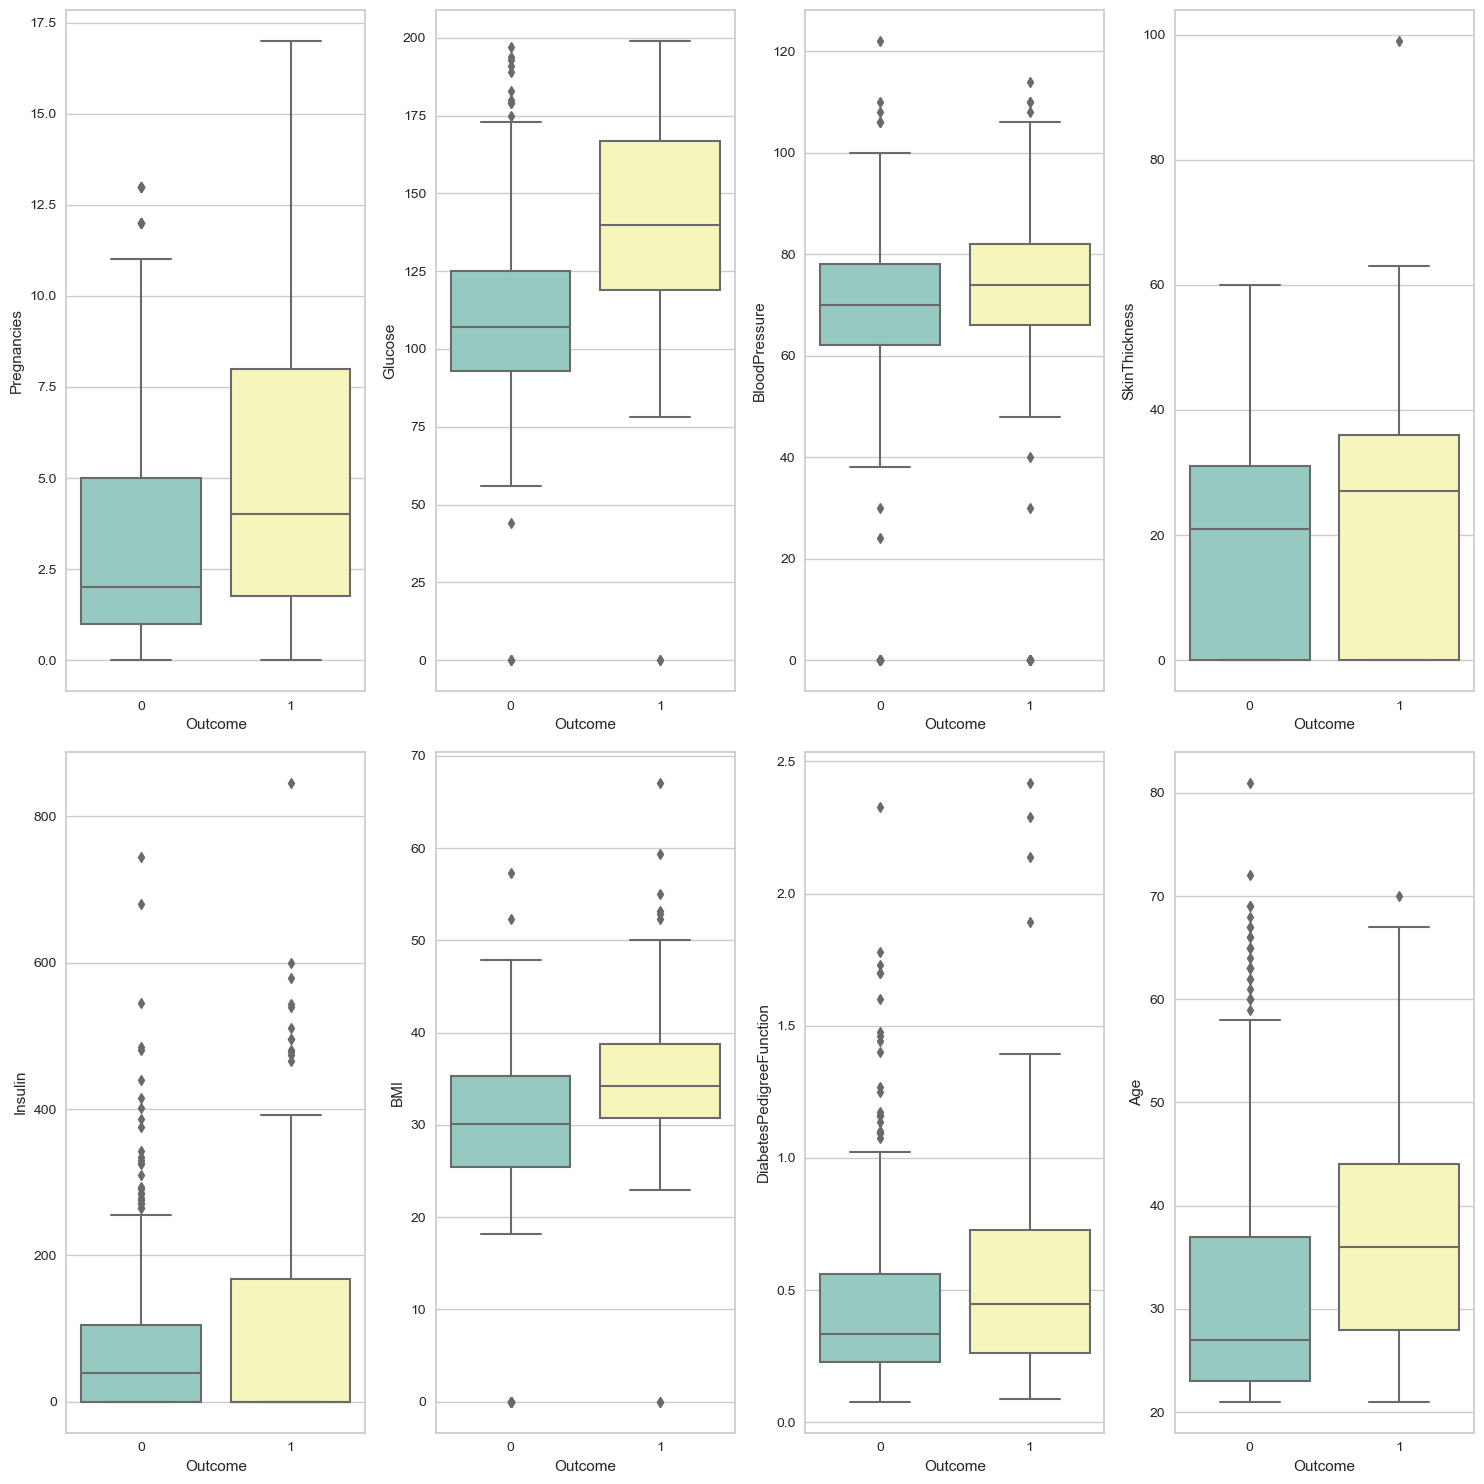

In [6]:
f, axes = plt.subplots(2, 4,figsize=(15,15))
sns.set(style="white", palette="Set3", color_codes=True)
sns.boxplot(  y="Pregnancies", x= "Outcome", data=df,  orient='v', ax=axes[0,0])
sns.boxplot(  y="Glucose", x= "Outcome", data=df,  orient='v' , ax=axes[0,1])
sns.boxplot(  y="BloodPressure", x= "Outcome", data=df,  orient='v' ,ax=axes[0,2])
sns.boxplot(  y="SkinThickness", x= "Outcome", data=df,  orient='v' , ax=axes[0,3])
sns.boxplot(  y="Insulin", x= "Outcome", data=df,  orient='v' ,  ax=axes[1,0])
sns.boxplot(  y="BMI", x= "Outcome", data=df,  orient='v' ,  ax=axes[1,1])
sns.boxplot(  y="DiabetesPedigreeFunction", x= "Outcome", data=df,  orient='v' , ax=axes[1,2])
sns.boxplot(  y="Age", x= "Outcome", data=df,  orient='v' ,  ax=axes[1,3])

f.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
#f.suptitle('Distribution of data')
plt.tight_layout()

From the above plot, we notice that no particular attribute clearly differentiates the two classes, though with attribute Glucose, the two classes seem to have a noticeable difference in their samples distribution. This variable could serve as a good differentiatior. 

We also note that the dataset contains samples with improbable values, such as samples which have zeros for the following attributes: BMI, Glucose, SkinThickness,Insulin,and BloodPressure. That does not make sense. Clearly, there might have been an error while recording the data or some data values might not have been recorded at all and instead filled with zeros. 

Next, we clean the data using basic techniques. We are not using any specialised method for data cleaning primarily because that is not the focus of this notebook. 

#### Data Cleaning
First we replace zeros with nan since after that counting them would be easier and zeros need to be replaced with suitable values.

In [7]:
df_copy = df.copy(deep = True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entries in each attribute:

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


To fill these Nan values the data distribution needs to be understood.

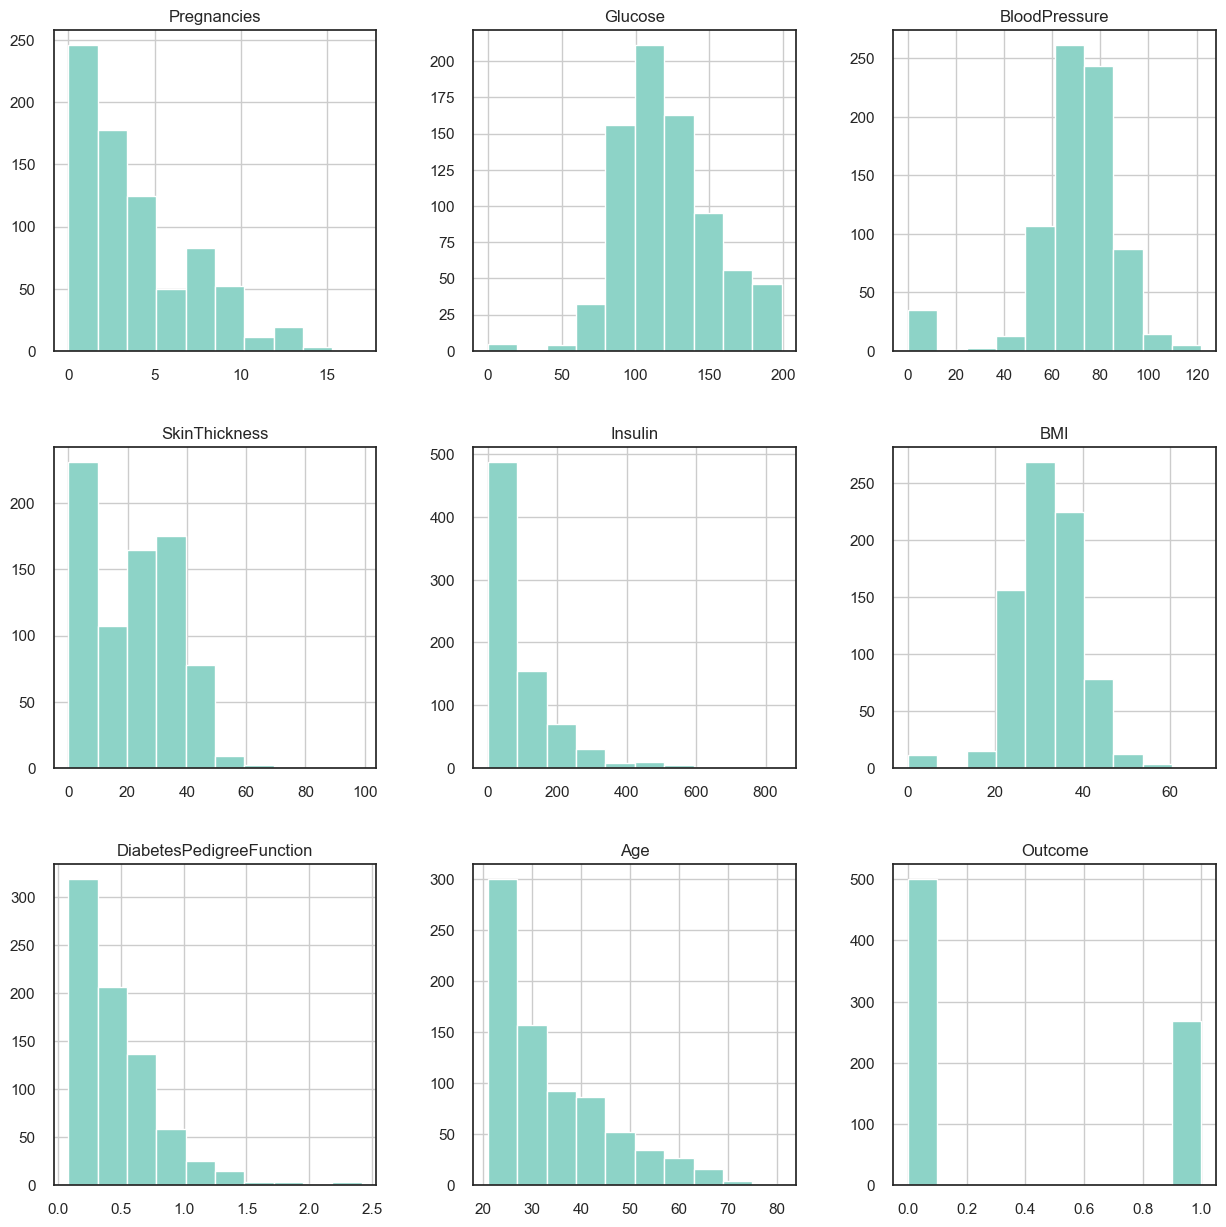

In [8]:
p = df.hist(figsize = (15,15))

In [9]:
#Impute NaN values using meadian values
print('Imputing NaN values')
df_copy['Glucose'].fillna(df_copy['Glucose'].median(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Imputing NaN values
Number of zero entries in each attribute:

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


This confirms we have no zero values in our data anymore. We continue exploring the distribution of the attributes and the relation between our attributes. Below is a correlation plot from which we gauge into the linear relationship between our attributes.

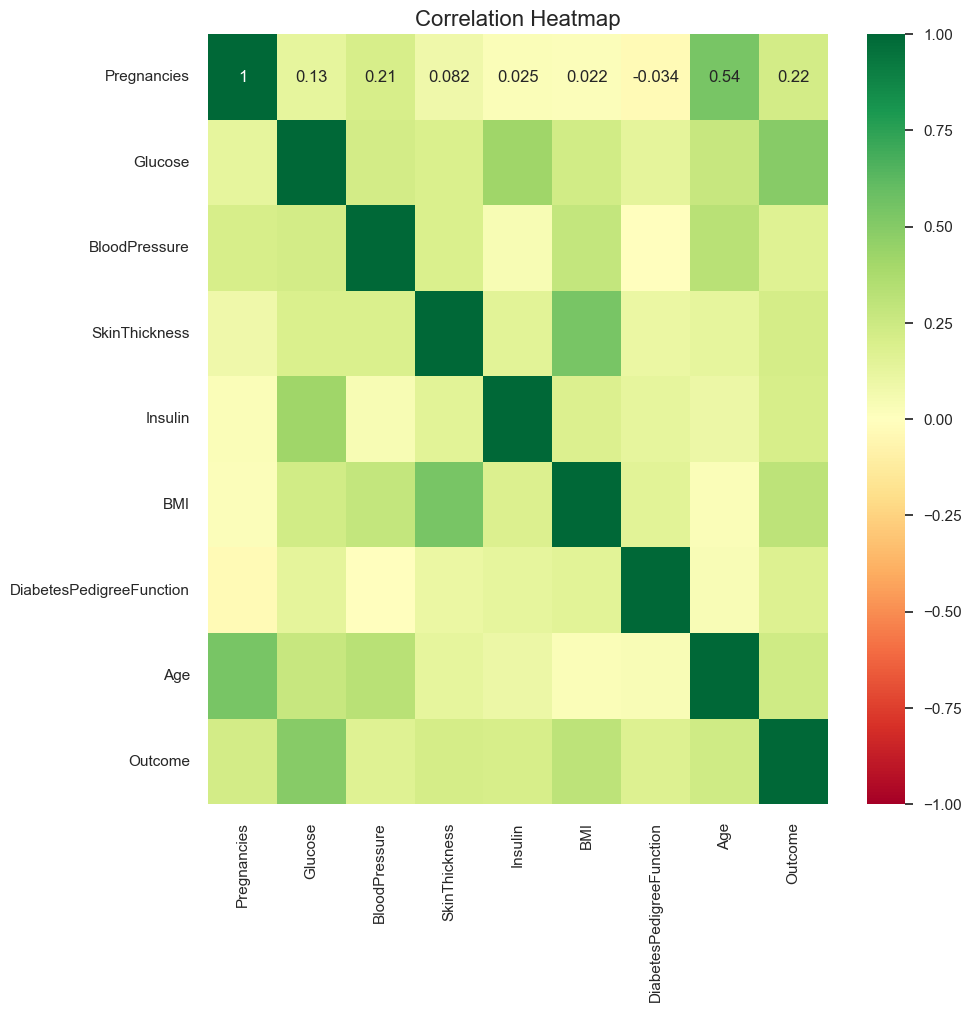

In [10]:
#plot the correlation map of the dataset  
plt.figure(figsize=(10,10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Pregnancies and Age are positively correlated, so are BMI and SkinThickness. As for the target variable, Glucose seems to be most linearly correlated with it. To further understand the bivariate relationships of the data, we draw pairplots.

## Model Building
In this section, we build several machine learning models and later analyse their results.
#### DummyClassifier
We start with the most basic, a dummy classifier which predicts the most frequent class at all times. This would serve as our baseline. 
Split X,y into train and test sets.

In [11]:
X = df_copy.iloc[:,0:8]
Y = df_copy.iloc[:,8]
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (614, 8)
Shape of X_test: (154, 8)


In [12]:
dum=DummyClassifier(strategy='most_frequent')
dum=dum.fit(X_train,y_train)

#compute accuracy
score=dum.score(X_test, y_test)
print("Dummy Classifier Accuracy: %.2f%%" % (score * 100.0))

Dummy Classifier Accuracy: 62.99%


<Figure size 700x700 with 0 Axes>

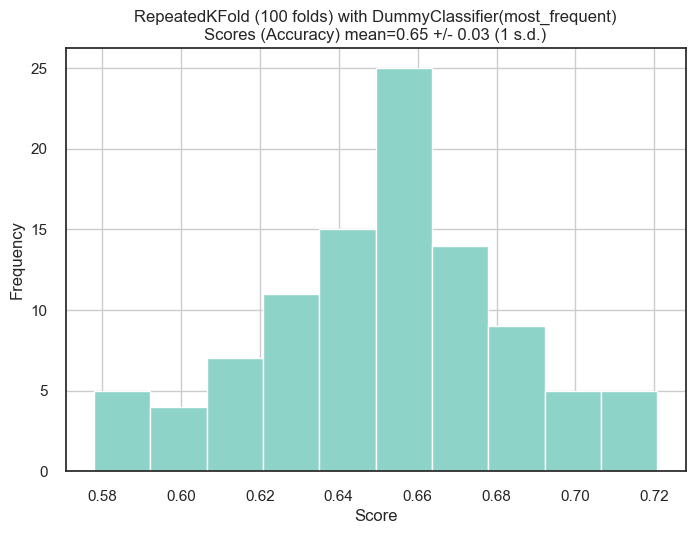

In [13]:
strategy = "most_frequent"

scores = cross_val_score(dum,X, Y, 
                         cv=RepeatedKFold(n_repeats=CV_N_REPEATS), 
                         scoring=None) 
scores_dummy = scores.copy()

score_line = "Scores (Accuracy) mean={0:.2f} +/- {1:.2f} (1 s.d.)".format(scores.mean(),scores.std())
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

#### K-Nearest Neighbors

In [14]:
knn=KNeighborsClassifier(n_neighbors=11) 
knn.fit(X_train,y_train)

#compute accuracy
scores = cross_val_score(knn, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f"Accuracy mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

Accuracy mean=0.74 +/- 0.04 (1 s.d.)


#### Decision tree 

We next train a decision tree classifier and check the accuracy results. 

In [15]:
dt=DecisionTreeClassifier(random_state=1, max_depth=2)
dt=dt.fit(X_train,y_train)
dt_scores = cross_val_score(dt, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f"Accuracy mean={dt_scores.mean():0.2f} +/- {dt_scores.std():0.2f} (1 s.d.)")

Accuracy mean=0.74 +/- 0.03 (1 s.d.)


### Bagging Classifier
This classifier fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. 
Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [16]:
bag=BaggingClassifier(n_estimators=100,oob_score=True) 
bag=bag.fit(X_train,y_train)

bag_scores = cross_val_score(bag, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print("Accuracy mean={0:0.2f} +/- {1:0.2f} (1 s.d.)".format(scores.mean(),scores.std()))
print("Out of bag score: {0:0.2f}".format(bag.oob_score_*100) );

Accuracy mean=0.74 +/- 0.04 (1 s.d.)
Out of bag score: 75.08


### Random Forest

In [19]:
num_estimators=100
rf = RandomForestClassifier(n_estimators=num_estimators) 
rf.fit(X_train, y_train)

rf_score=rf.score(X_test, y_test)
print("Accuracy of Random Forest Classifier: {0:0.2f}".format(rf_score * 100.0));

#Make Predictions
y_pred = rf.predict(X_test)
#Plot the confusion matrix
confusion_matrix(y_pred, y_test)

Accuracy of Random Forest Classifier: 81.17


array([[88, 20],
       [ 9, 37]], dtype=int64)

From the random forest model, we have 35 incorrectly labeled samples. In medical data analaysis, as it is usually the case, we are more concerned about the False Negatives (or Misses), i.e. diabetic samples who have been incorrectly labelled as non-diabetic. This model results in 15 such cases. 

We use the eli5 library to analyse which are the most important features for our learned RF model

In [20]:
feature_names=X_train.columns.values
show_weights(rf,feature_names=feature_names)

Weight,Feature
0.2511 ± 0.1149,Glucose
0.1682 ± 0.0971,BMI
0.1317 ± 0.0621,DiabetesPedigreeFunction
0.1256 ± 0.0786,Age
0.0865 ± 0.0739,Insulin
0.0841 ± 0.0479,BloodPressure
0.0788 ± 0.0528,Pregnancies
0.0741 ± 0.0520,SkinThickness


As expected, Glucose turns out to be the most important feature for our RF model. This affirms our intuition formed during the data exploration phase. 
#### Check variance in RF prediction quality


Scores mean=0.76 +/- 0.02 (1 s.d.)


<Figure size 800x550 with 0 Axes>

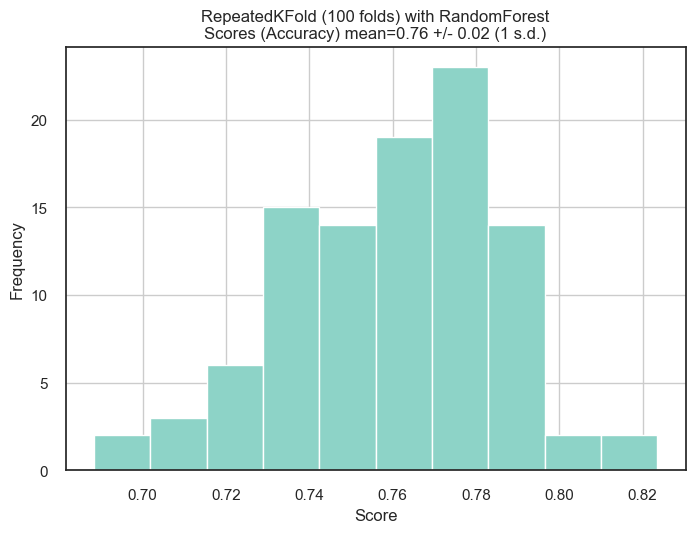

In [21]:
scores = cross_val_score(rf, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

 We compare the prediction performance of our random forest classifier against the Dummy classifier. 

<Figure size 800x550 with 0 Axes>

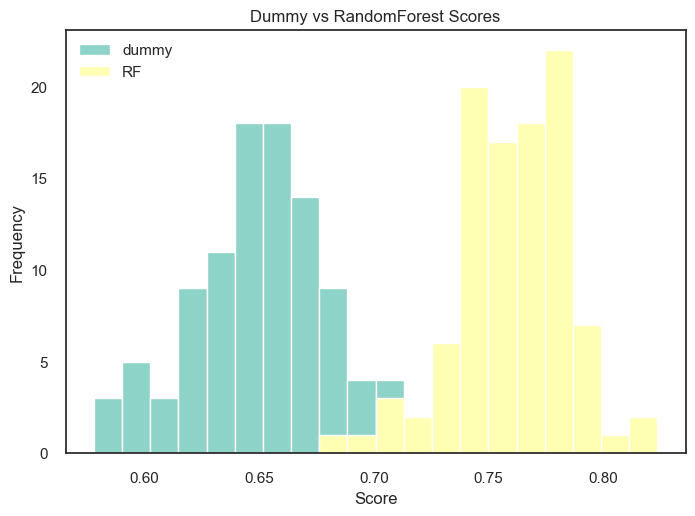

In [22]:
plt.figure()
fig, ax = plt.subplots()
df_dummy_est_scores = pd.DataFrame({'dummy': scores_dummy, 'RF': scores_est})
df_dummy_est_scores.plot(kind='hist', ax=ax, bins=20)
ax.set_xlabel("Score")
ax.set_title("Dummy vs RandomForest Scores");

Starting with a dummy classifier, we can confirm that we have made some progress in the right direction to predict for onset of diabetes. 

### GradientBoostingClassifier (Sklearn)
This is an ensemble model based on the boosting paradigm, i.e. sequential model building using several weak classifiers. We start with 500 estimators and a decision tree classifier of depth 4 as our weak learner. 

In [23]:
from sklearn.metrics import mean_squared_error
params={'n_estimators': 500,'learning_rate': 0.01,'max_depth': 4, 'loss':'deviance'}
gbm=GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, loss='deviance', max_depth=4,
                           n_estimators=500)

Let's see how the model deviance performs w.r.t the number of estimators. Deviance is the logistic loss function used in all implementation of GBM and is the default loss function for classification problems. 

Text(0, 0.5, 'Deviance')

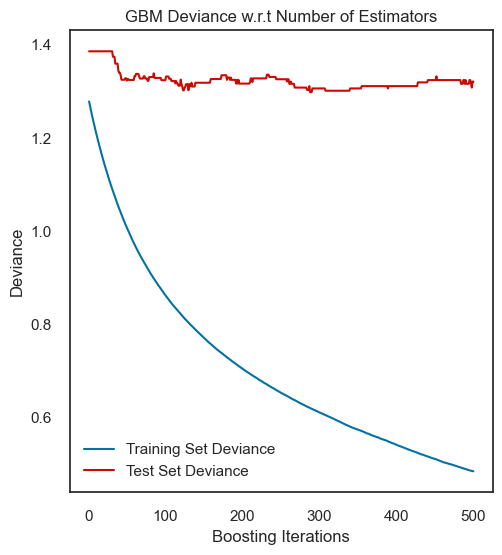

In [24]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = gbm.loss_(y_test, y_pred)

#plot train and test set deviance against the number of estimators
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('GBM Deviance w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-',label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

As we can see from the plot above that the test set deviance plateaus at around 1.3 at about 100 estimators. Having more estimators would not help in predictions, in fact it would lead model to overfit the training data.
We set the number of estimators to 100 and retrain our GBM. We also plot the confusion matrix to check for errors. As can be seen, GBM does a good job at reducing the False Negative to 7 from 14 in the random forest model, though the number of false positive detections has increased to 33 is not so good.

In [26]:
params={'n_estimators': 100,'learning_rate': 0.01,'max_depth': 4, 'loss':'deviance'}
gbm=GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

# make predictions for test data
y_pred = gbm.predict(X_test)

# evaluate predictions
gbm_score = accuracy_score(y_test, y_pred)
print("Accuracy of GBM Classifier: {0:0.2f}".format(gbm_score * 100.0));

#Plot the confusion matrix
confusion_matrix(y_pred, y_test)

Accuracy of GBM Classifier: 74.03


array([[90, 33],
       [ 7, 24]], dtype=int64)

Plot Feature Importance for the GBM model

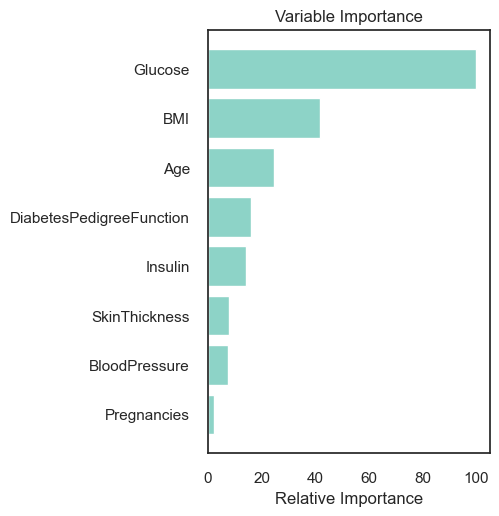

In [27]:
feature_importance = gbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### XgBoost

This model is an optimized variant of the Gradient boosting models, which at its core does the same work as the previous Gradient Boosting machine does. The difference is that XgBoost algorithm is developed with both deep consideration in terms of systems optimization and principles in machine learning. The goal of the library is to push the extreme of the computation limits of machines to provide a scalable, portable and accurate library. 

In [29]:
from xgboost import XGBClassifier, plot_importance,to_graphviz

# fit model on training data
param = {'max_depth': 3, 'eta': 0.8, 'subsample':1, 'objective': 'binary:logistic'}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [31]:
# make predictions for test data
y_pred = xgb.predict(X_test)

# evaluate predictions
xgb_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGB Classifier: {0:0.2f}".format(xgb_score * 100.0));

#Plot the confusion matrix
confusion_matrix(y_pred, y_test)

Accuracy of XGB Classifier: 70.13


array([[73, 22],
       [24, 35]], dtype=int64)

XGBoost in most cases performs better than GBM.  As we can see here the classification accuracy has increased to 83.12% than compared to GBM's 74%, but the Misses have increased from 7 in GBM to 19 with Xgboost model.  

Next we plot Feature Importance based on the Xgboost model. From the feature importance graphs for all models plotted until now, we see Glucose is the most important feature. Importance order for the other features is more or less same.

<Figure size 800x550 with 0 Axes>

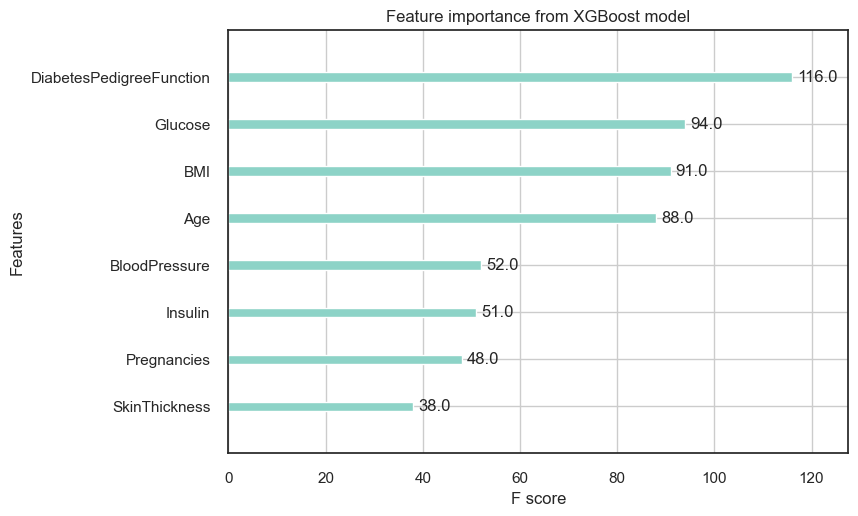

In [32]:
# plot feature importance using built-in function
plt.figure()
plot_importance(xgb,title="Feature importance from XGBoost model")
plt.show()

## Stacking
Stacking is a way of combining multiple models, that introduces the concept of a meta learner. It is less widely used than bagging and boosting. Unlike bagging and boosting, stacking may be (and normally is) used to combine models of different types.

The point of stacking is to explore a space of different models for the same problem. The idea is that you can attack a learning problem with different types of models which are capable to learn some part of the problem, but not the whole space of the problem. So you can build multiple different learners and you use them to build an intermediate prediction, one prediction for each learned model. Then you add a new model which learns from the intermediate predictions the same target. This final model is said to be stacked on the top of the others, hence the name. Thus you might improve your overall performance, and often you end up with a model which is better than any individual intermediate model.

In [34]:
from mlxtend.classifier import StackingCVClassifier

sclf = StackingCVClassifier(classifiers=[knn, rf, xgb, gbm], 
                          meta_classifier=rf)

print('10-fold cross validation:\n')

for clf, label in zip([knn, rf, xgb, gbm, rf], 
                      ['KNearest Neighbors',
                       'Random Forest', 
                        'XGB','GBM',
                       'MetaClassifier']):

    sclf_scores = model_selection.cross_val_score(clf, X, Y,
                                              cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (sclf_scores.mean(), sclf_scores.std(), label))

10-fold cross validation:

Accuracy: 0.74 (+/- 0.05) [KNearest Neighbors]
Accuracy: 0.76 (+/- 0.05) [Random Forest]
Accuracy: 0.72 (+/- 0.05) [XGB]
Accuracy: 0.75 (+/- 0.04) [GBM]
Accuracy: 0.76 (+/- 0.05) [MetaClassifier]


## Summarize results
We run the algorithms once again using StratifiedK-fold cross-validation and summarize our findings. 

In [35]:
models = []
#models.append(('LR', LogisticRegression()))
models.append(('KNN', knn))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('GBM', gbm))
models.append(('XGB', xgb))

 Every algorithm is tested and results are collected and printed. We then visualise the variation in the predictions of each algorithm using a boxplot.

In [36]:
results = []
names = []

for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)
    
#Add stacking results that we got previously
results.append(np.asarray(sclf_scores))
names.append('Stacking')

KNN: 0.5897435897435898 (0.0928552050583035)
DT: 0.44401709401709405 (0.14560056161577256)
RF: 0.5967236467236468 (0.0804570964688931)
GBM: 0.49230769230769234 (0.0954037429721667)
XGB: 0.5964387464387465 (0.10288027004577623)


We end the analysis with classification report of our two best performing models.The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem. Visual classification reports are used to compare classification models to select models that are “redder”, e.g. have stronger classification metrics or that are more balanced.

Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. 

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.

Based on recall, XgBoost and RandomForest is a better classifier. So was the case when we considered number of False negatives samples. 

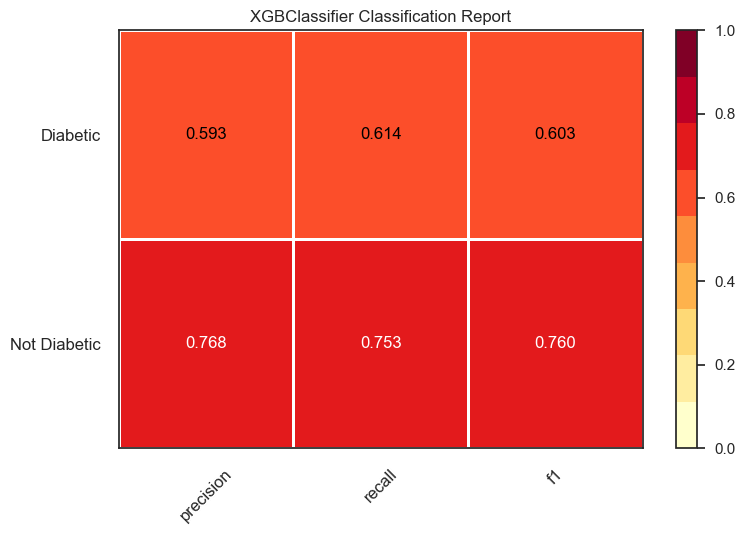

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [37]:
visualizer = ClassificationReport(xgb,classes=['Not Diabetic','Diabetic'])

#visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)   # Evaluate the model on the test data
visualizer.poof()                  # Draw/show/poof the data

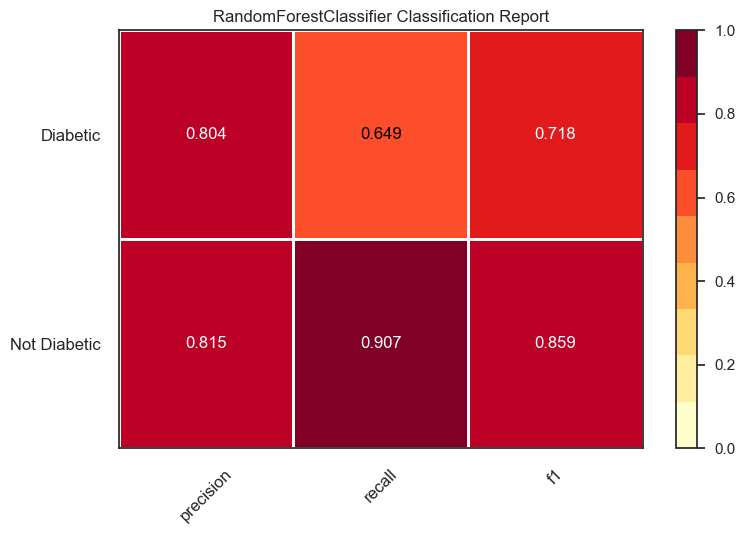

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [38]:
visualizer = ClassificationReport(rf,classes=['Not Diabetic','Diabetic'])

#visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)   # Evaluate the model on the test data
visualizer.poof()                  # Draw/show/poof the data